# Gradient descent algorithm for Scenario 2


In this part, we implement an gradient descent algorithm to optimization the objective loss function in Scenario 2:


$$\min F := \min \frac{1}{2(n-i)} \sum_{i=1000}^n (fbpredic(i) + a*tby(i) +b*ffr(i) + c*fta(i) - asp(i))^2$$

Gradient descent: 

$$ \beta_k = \beta_{k-1} + \delta* \nabla F, $$
where $\delta$ control how far does each iteration go.


### Detailed plan

First, split the data as train and test with 80% and 20% respectively. For the training part, we need prophet() predicted price, there are a couple of issues. One is prophet() can not predict too far in the future. The other is we can not call prophet() too many times, this takes a lot of time. So we will use a sliding window strategy:

1, Split the train data as train_1 and train_2, where train_1 is used as a sliding window to fit prophet(), and give predictions in train_2. Train_2 is used train the model we proposed above.

2, After we got full size (size of train_2) predictions from prophet(), then we use gradient descent to fit the above model, extracting the coefficients of features to make predicution in the testing data.

In [82]:
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
from matplotlib import style
import datetime as dt
import seaborn as sns
sns.set_style("whitegrid")

In [83]:
path = '/Users/yuqingdai/Documents/GitHub/Stock-Erdos/scratch work/Yuqing-Data-Merge/Data/dt'


In [84]:
df= pd.read_csv(path+'/dff1.csv')
df = df.rename(columns = {"Date":"ds","Close":"y"}) 
df = df[['ds', 'y', 'fbsp','diff', 'tby', 'ffr', 'fta', 'eps', 'div', 'per', 'une', 'rus',
       'wti', 'ppi', 'rfs', 'vix']]
df

,ds,y,fbsp,diff,tby,ffr,fta,eps,div,per,une,rus,wti,ppi,rfs,vix
0,2009-12-07,1103.25,1105.078898,-1.828898,3.44,0.12,2204380.0,46.72,2.10,21.8776,9.9,603.559998,73.89,178.1,346072.0,22.50
1,2009-12-08,1091.94,1107.123090,-15.183090,3.40,0.12,2204380.0,46.72,2.10,21.8776,9.9,597.700012,72.59,178.1,346072.0,23.48
2,2009-12-09,1095.95,1113.700610,-17.750610,3.45,0.12,2186762.0,46.72,2.10,21.8776,9.9,598.030029,70.67,178.1,346072.0,23.05
3,2009-12-10,1102.35,1115.769261,-13.419261,3.49,0.12,2186762.0,46.72,2.10,21.8776,9.9,595.380005,70.54,178.1,346072.0,22.50
4,2009-12-11,1106.41,1117.682964,-11.272964,3.55,0.12,2186762.0,46.72,2.10,21.8776,9.9,600.369995,69.86,178.1,346072.0,22.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2547,2020-02-24,3225.89,3085.074930,140.815070,1.38,1.58,4171570.0,135.28,1.79,25.3952,3.5,1628.099976,51.36,196.7,525810.0,20.15
2548,2020-02-25,3128.21,3085.493162,42.716838,1.33,1.58,4171570.0,135.28,1.79,25.3952,3.5,1571.900024,49.78,196.7,525810.0,21.95
2549,2020-02-26,3116.39,3086.398961,29.991039,1.33,1.58,4158637.0,135.28,1.79,25.3952,3.5,1552.760010,48.67,196.7,525810.0,22.45
2550,2020-02-27,2978.76,3085.948568,-107.188568,1.30,1.58,4158637.0,135.28,1.79,25.3952,3.5,1497.869995,47.17,196.7,525810.0,26.60


In [88]:
# p=0.9
# cutoff = int(p * len(df))
cutoff = len(df) - 252
df_train = df[:cutoff].copy()
df_test = df[cutoff:].copy()

In [89]:
cutoff

2300

In [90]:
df.columns

Index(['ds', 'y', 'fbsp', 'diff', 'tby', 'ffr', 'fta', 'eps', 'div', 'per',
       'une', 'rus', 'wti', 'ppi', 'rfs', 'vix'],
      dtype='object')

In [91]:
possible_features = ['tby', 'ffr', 'fta', 'eps', 'div', 'per',
       'une', 'rus', 'wti', 'ppi', 'rfs', 'vix']

from itertools import chain, combinations

def powerset(iterable):
    #"powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))


#print(list(powerset(possible_features)))

In [92]:
len(possible_features)

12

In [93]:
from statsmodels.regression.linear_model import OLS

reg_new = OLS((df_train['diff']).copy(),df_train[possible_features].copy()).fit()
print(reg_new.params)

#from the output, we can see it's consistent with sklearn output

tby   -100.625610
ffr   -109.406805
fta     -0.000121
eps     -7.622956
div   -503.127084
per     -4.512674
une     72.649220
rus      0.654320
wti      2.368703
ppi     -2.489185
rfs      0.004539
vix    -10.153710
dtype: float64


In [94]:
new_coef = reg_new.params
new_possible_feats = new_coef[abs(new_coef)>0].index

power_feats = list(powerset(new_possible_feats))
power_feats.remove(())

power_feats = [ list(feats) for feats in power_feats]
power_feats 


[['tby'],
 ['ffr'],
 ['fta'],
 ['eps'],
 ['div'],
 ['per'],
 ['une'],
 ['rus'],
 ['wti'],
 ['ppi'],
 ['rfs'],
 ['vix'],
 ['tby', 'ffr'],
 ['tby', 'fta'],
 ['tby', 'eps'],
 ['tby', 'div'],
 ['tby', 'per'],
 ['tby', 'une'],
 ['tby', 'rus'],
 ['tby', 'wti'],
 ['tby', 'ppi'],
 ['tby', 'rfs'],
 ['tby', 'vix'],
 ['ffr', 'fta'],
 ['ffr', 'eps'],
 ['ffr', 'div'],
 ['ffr', 'per'],
 ['ffr', 'une'],
 ['ffr', 'rus'],
 ['ffr', 'wti'],
 ['ffr', 'ppi'],
 ['ffr', 'rfs'],
 ['ffr', 'vix'],
 ['fta', 'eps'],
 ['fta', 'div'],
 ['fta', 'per'],
 ['fta', 'une'],
 ['fta', 'rus'],
 ['fta', 'wti'],
 ['fta', 'ppi'],
 ['fta', 'rfs'],
 ['fta', 'vix'],
 ['eps', 'div'],
 ['eps', 'per'],
 ['eps', 'une'],
 ['eps', 'rus'],
 ['eps', 'wti'],
 ['eps', 'ppi'],
 ['eps', 'rfs'],
 ['eps', 'vix'],
 ['div', 'per'],
 ['div', 'une'],
 ['div', 'rus'],
 ['div', 'wti'],
 ['div', 'ppi'],
 ['div', 'rfs'],
 ['div', 'vix'],
 ['per', 'une'],
 ['per', 'rus'],
 ['per', 'wti'],
 ['per', 'ppi'],
 ['per', 'rfs'],
 ['per', 'vix'],
 ['une', 'rus

In [95]:
AIC_scores = []
parameters = []

for feats in power_feats:
    tmp_reg = OLS((df_train['diff']).copy(),df_train[feats].copy()).fit()
    AIC_scores.append(tmp_reg.aic)
    parameters.append(tmp_reg.params)

    
Min_AIC_index = AIC_scores.index(min(AIC_scores))
Min_AIC_feats = power_feats[Min_AIC_index]  
Min_AIC_params  = parameters[Min_AIC_index]
print(Min_AIC_feats)
print(Min_AIC_params)  

['tby', 'ffr', 'fta', 'eps', 'div', 'per', 'une', 'rus', 'wti', 'ppi', 'rfs', 'vix']
tby   -100.625610
ffr   -109.406805
fta     -0.000121
eps     -7.622956
div   -503.127084
per     -4.512674
une     72.649220
rus      0.654320
wti      2.368703
ppi     -2.489185
rfs      0.004539
vix    -10.153710
dtype: float64


In [96]:
###After selecting the best features, we report the testing error, and make the plot 
AIC_df_test = df_test[Min_AIC_feats]
AIC_pred_test = AIC_df_test.dot(Min_AIC_params)+df_test.fbsp

AIC_df_train = df_train[Min_AIC_feats]
AIC_pred_train = AIC_df_train.dot(Min_AIC_params)+ df_train.fbsp



In [97]:
from sklearn.metrics import mean_squared_error as MSE

mse_train = MSE(df_train.y, AIC_pred_train) 
mse_test = MSE(df_test.y, AIC_pred_test)


#compare with fbprophet()

fb_mse_train = MSE(df_train.y, df_train.fbsp) 
fb_mse_test = MSE(df_test.y, df_test.fbsp)


print(mse_train,fb_mse_train)

print(mse_test,fb_mse_test)

4228.814511096513 17643.826224878187
14857.510338989307 15046.462930803766


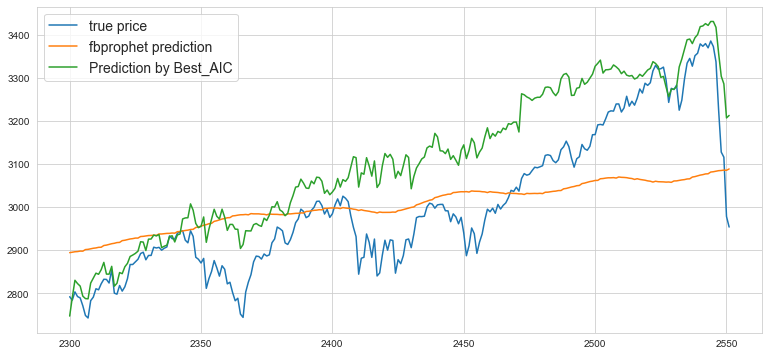

In [98]:
plt.figure(figsize=(13,6))
plt.plot(df_test.y,label="true price")
plt.plot(df_test.fbsp,label="fbprophet prediction")
plt.plot(AIC_pred_test,label="Prediction by Best_AIC")
plt.legend(fontsize = 14)
plt.show()